In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('Data/processed.csv')
df.head()

,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,year,month,day,hour,cluster
0,2022-01-01,11.021500,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,2022,1,1,0,4
1,2022-01-01,10.521500,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,2022,1,1,1,4
2,2022-01-01,10.721499,96.0,8.677092,0.0,0.0,0.0,0.0,1019.8,1018.69610,100.0,14.345898,197.52567,39.96,0.0,2022,1,1,2,4
3,2022-01-01,11.071500,97.0,9.138726,0.0,0.0,0.0,0.0,1019.7,1018.59784,100.0,14.587776,195.75124,42.12,0.0,2022,1,1,3,4
4,2022-01-01,11.221499,96.0,8.969191,0.0,0.0,0.0,0.0,1019.5,1018.39825,100.0,16.766108,194.93147,49.32,0.0,2022,1,1,4,4


In [4]:
df.isna().sum()

date                    0
temperature_2m          0
relative_humidity_2m    0
apparent_temperature    0
precipitation           0
rain                    0
showers                 0
snowfall                0
pressure_msl            0
surface_pressure        0
cloud_cover             0
wind_speed_10m          0
wind_direction_10m      0
wind_gusts_10m          0
is_day                  0
year                    0
month                   0
day                     0
hour                    0
cluster                 0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

### EDA

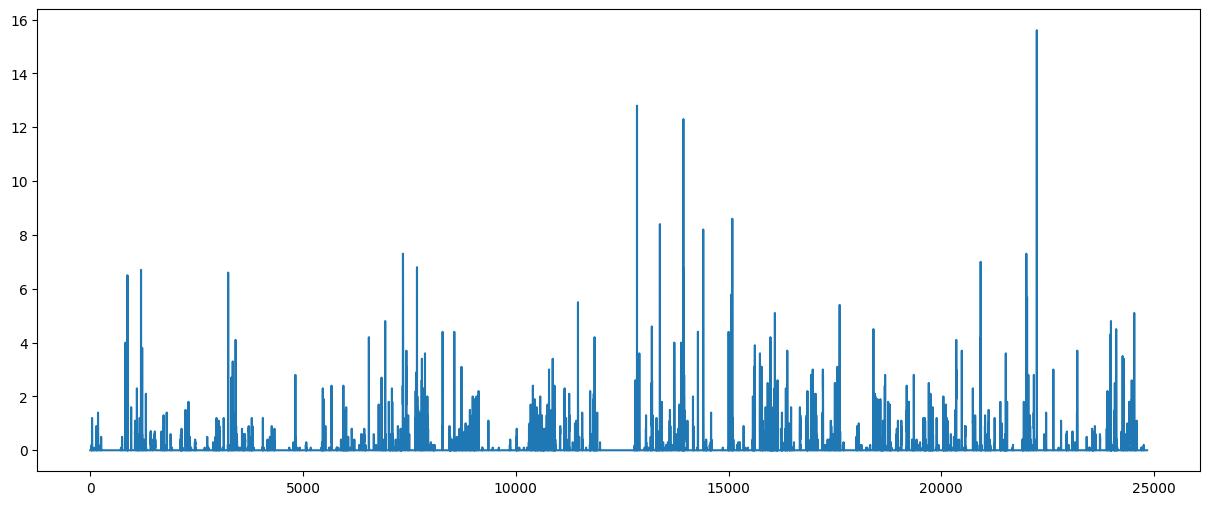

In [6]:
plt.figure(figsize=(15,6), dpi = 100) 
plt.plot(df['precipitation'], linestyle = 'solid') #solid, dashed, dashdot, dotted
plt.show()

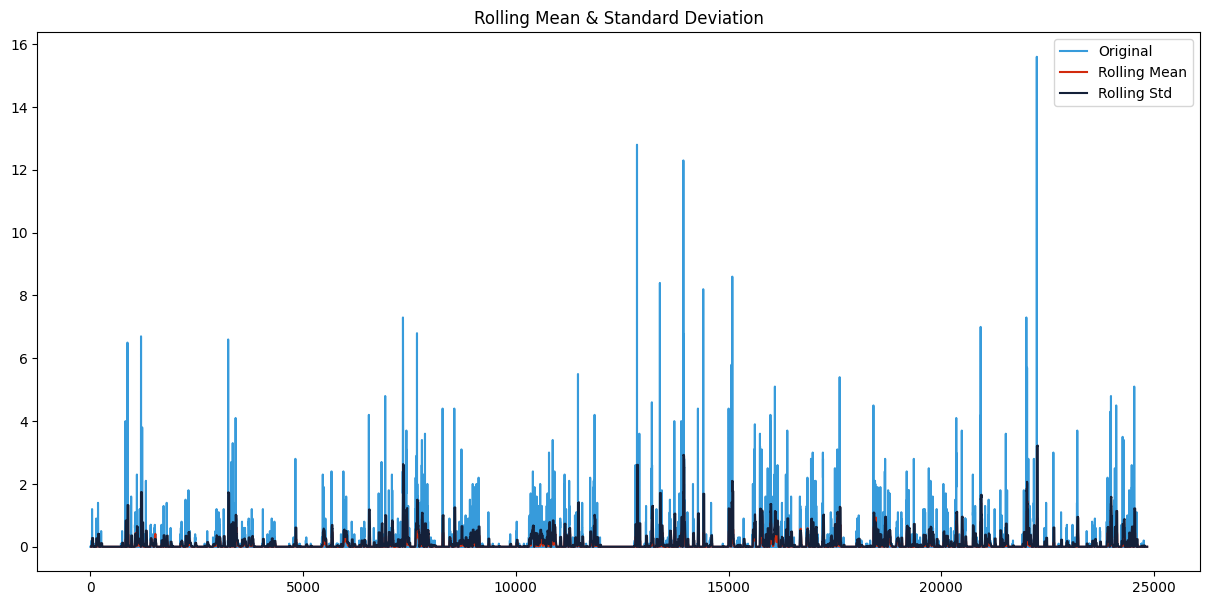

In [7]:
#Plot rolling statistics
plt.figure(figsize=(15,7))
plt.plot(df["precipitation"], color='#379BDB', label='Original')
plt.plot(df["precipitation"].rolling(window=24).mean(), color='#D22A0D', label='Rolling Mean')
plt.plot(df["precipitation"].rolling(window=24).std(), color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

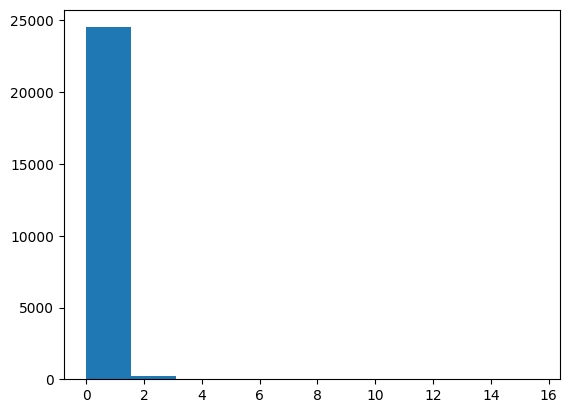

In [8]:
plt.hist(df['precipitation'])
plt.show()

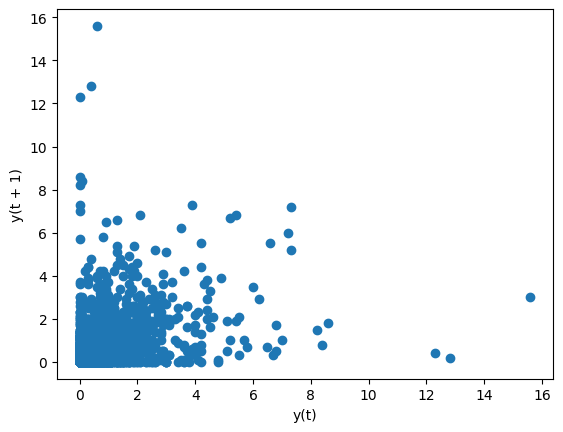

In [9]:
from pandas.plotting import lag_plot

lag_plot(df['precipitation'])
plt.show()

In [10]:
# Checking auto-correlation
from pandas import concat

btc_price = df['precipitation']
dataframe = concat([btc_price.shift(1), btc_price], axis=1)
dataframe.columns = ['t', 't+1']
result = dataframe.corr()
result

,t,t+1
t,1.000000,0.509739
t+1,0.509739,1.000000


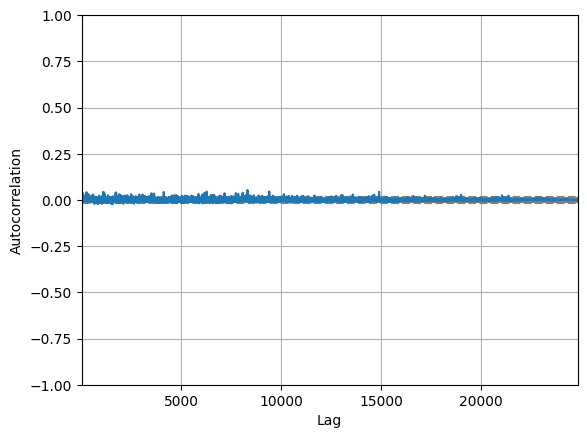

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['precipitation'])
plt.show()

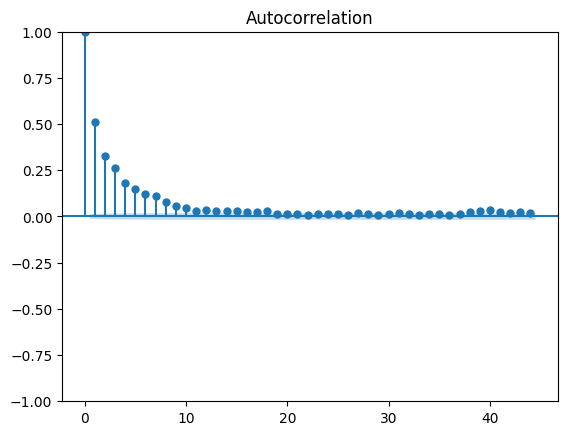

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['precipitation'])
plt.show()

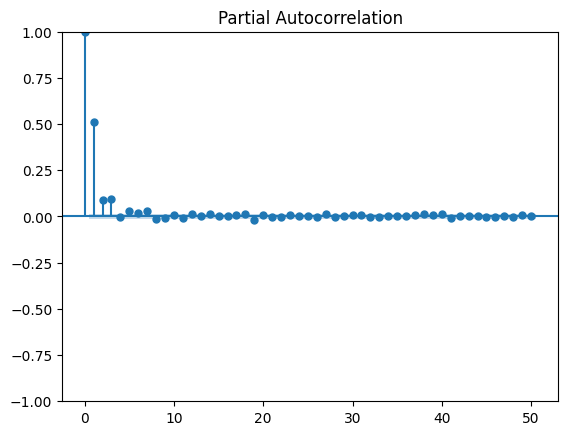

In [13]:
plot_pacf(df['precipitation'], lags=50)
plt.show()

### Data transformation

In [14]:
df = df.drop(['year', 'date'], axis = 1)
df.head(2)

,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,showers,snowfall,pressure_msl,surface_pressure,cloud_cover,wind_speed_10m,wind_direction_10m,wind_gusts_10m,is_day,month,day,hour,cluster
0,11.0215,93.0,8.542295,0.0,0.0,0.0,0.0,1019.9,1018.79724,7.0,16.981165,212.00534,51.12,0.0,1,1,0,4
1,10.5215,95.0,8.323380,0.0,0.0,0.0,0.0,1019.7,1018.59550,19.0,14.707222,201.54105,43.56,0.0,1,1,1,4


<Axes: >

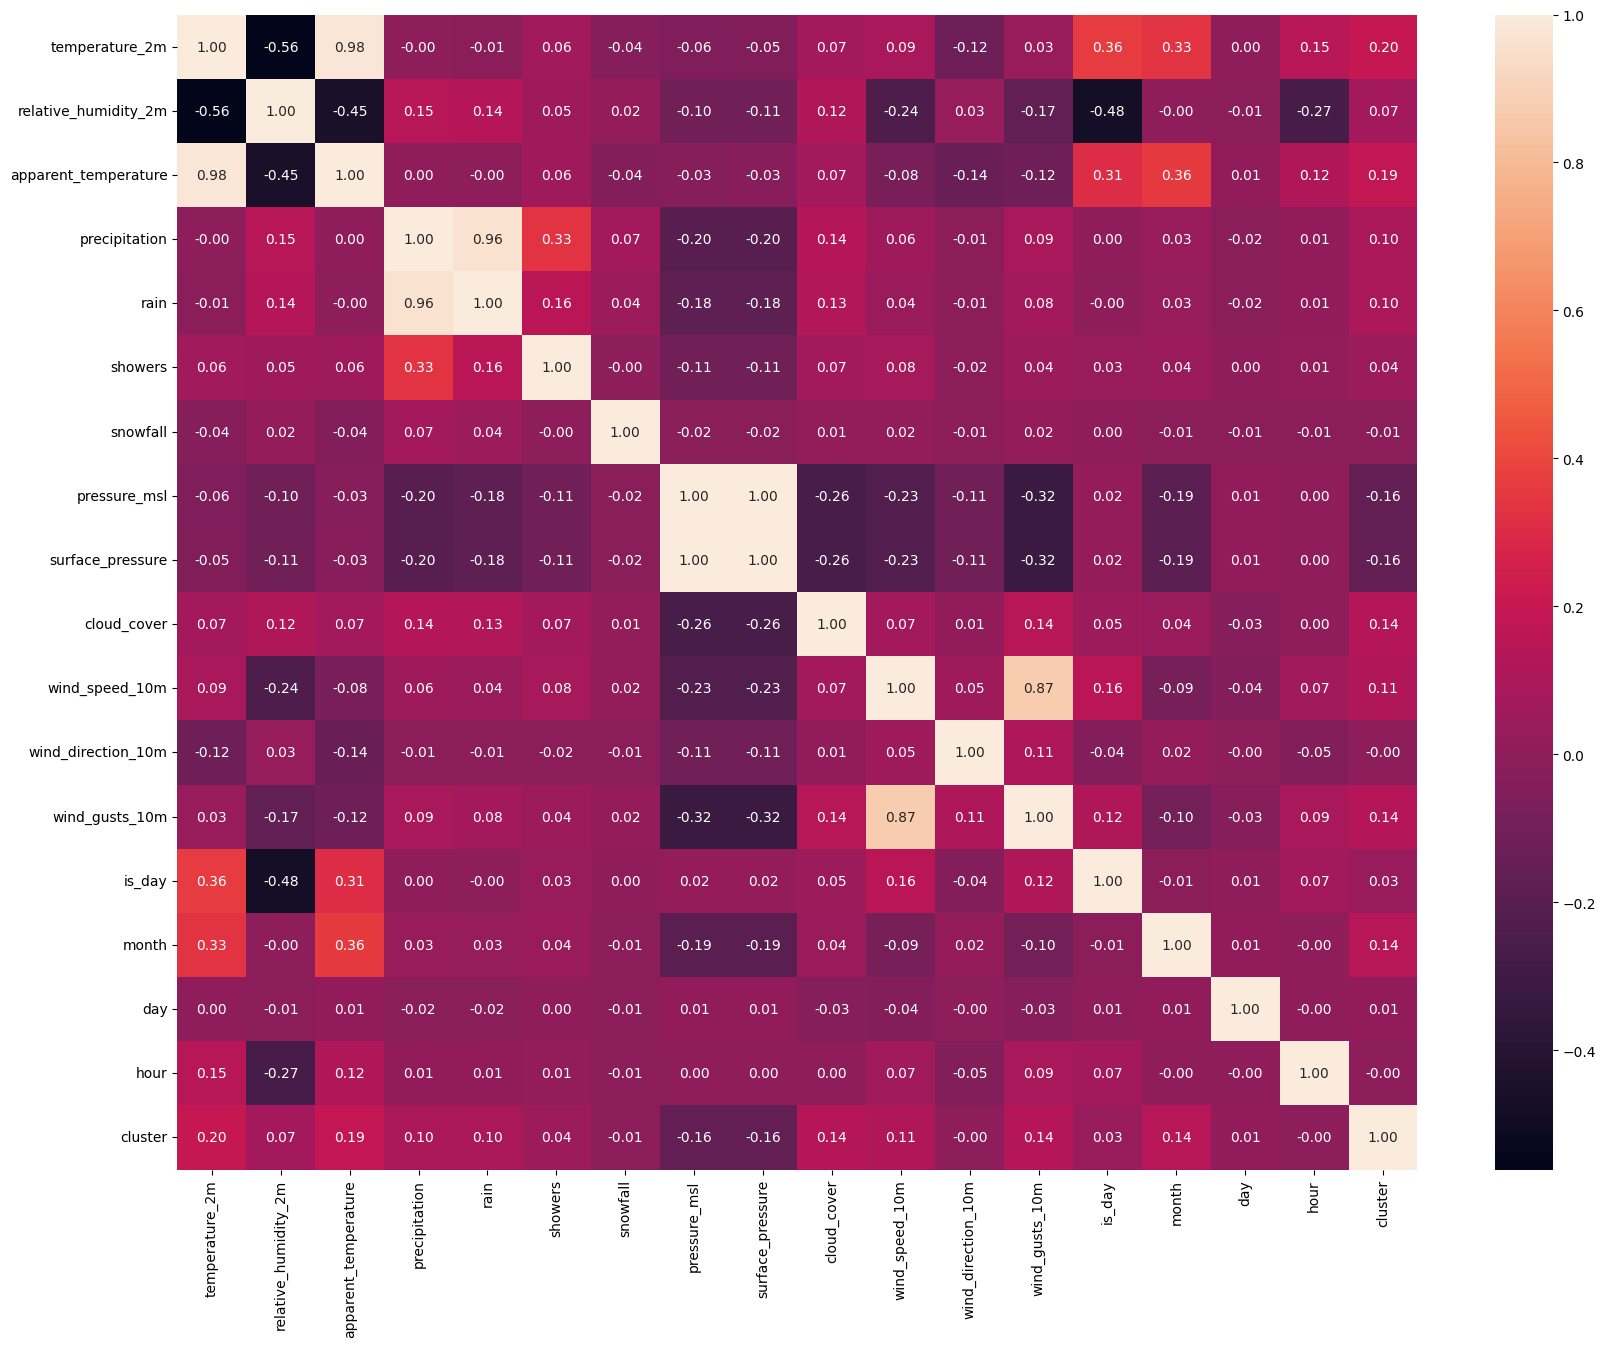

In [15]:
# Create correlation matrix heat map to check multi-collinearity between columns.

plt.figure(figsize = (20,15), dpi = 100)
sns.heatmap(df.corr(), annot = True, fmt = '.2f')

### Stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['precipitation'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -31.232313282609894
p-value: 0.0


### Data Splitting and scaling

In [17]:
len(df.index) - (len(df.index) * 20 /100)

19872.0

In [18]:
train = df.iloc[:19872]
test = df.iloc[19872:]
test.reset_index(drop = True, inplace = True)

In [19]:
x_train = train.drop('precipitation', axis = 1)
y_train = train[['precipitation']]
x_test = test.drop('precipitation', axis = 1)
y_test = test[['precipitation']]

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19872, 17)
(19872, 1)
(4968, 17)
(4968, 1)


### Feature Selection

In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Step 1: Standardize the features
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [22]:
lasso = LassoCV(cv=5, random_state=42)  # 5-fold cross-validation
lasso.fit(x_train, y_train)

c:\Users\viren\Portfolio\Weather\.conda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1656: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(cv=5, random_state=42)

In [23]:
# Get the coefficients
feature_names = list(train.columns)
feature_names.remove('precipitation')
lasso_coefficients = lasso.coef_

# Identify selected features
selected_features_indices = np.where(lasso_coefficients != 0)[0]
selected_feature_names = [feature_names[i] for i in selected_features_indices]
selected_coefficients = lasso_coefficients[selected_features_indices]

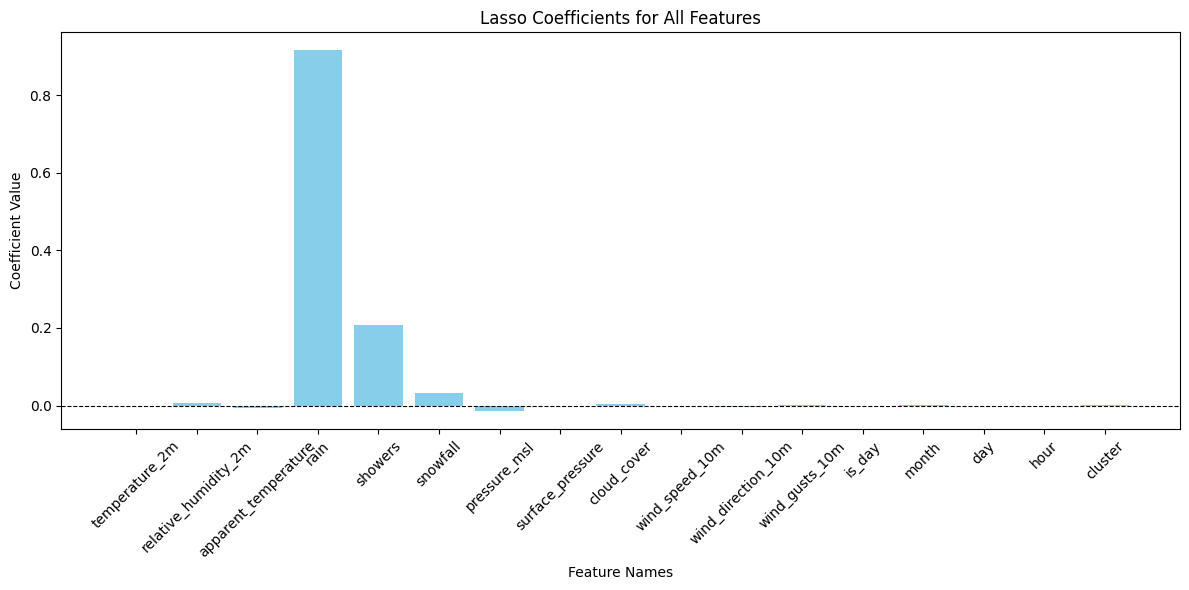

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(feature_names, lasso_coefficients, color='skyblue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Lasso Coefficients for All Features")
plt.xlabel("Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

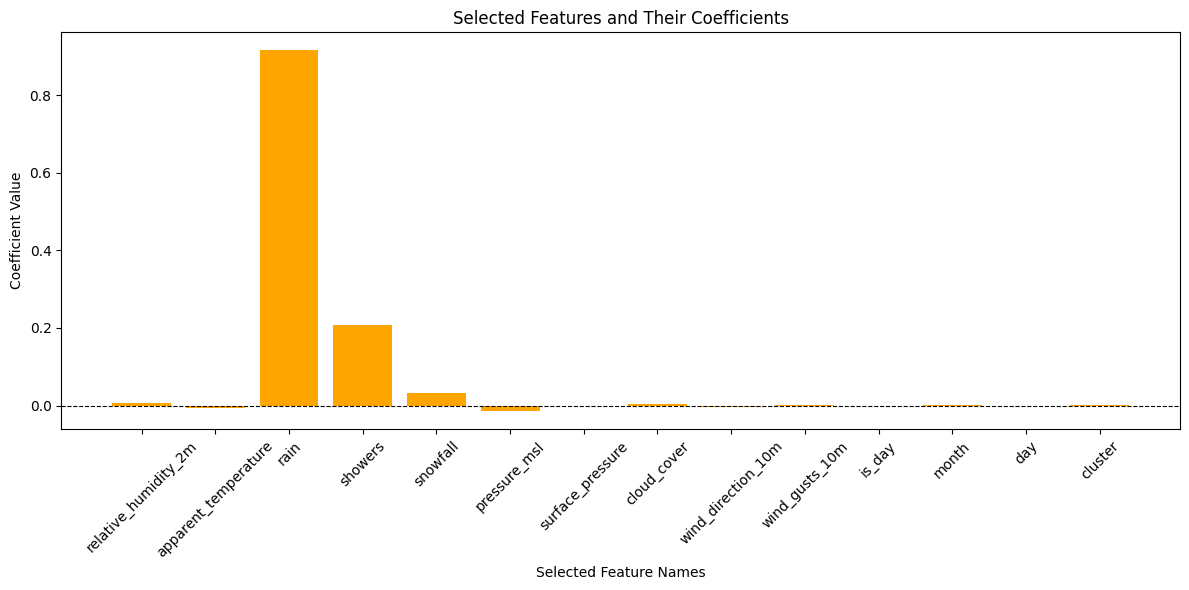

In [25]:
plt.figure(figsize=(12, 6))
plt.bar(selected_feature_names, selected_coefficients, color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Selected Features and Their Coefficients")
plt.xlabel("Selected Feature Names")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
selected_coefficients

array([ 5.34640129e-03, -5.31560396e-03,  9.15422117e-01,  2.08806370e-01,
        3.27709079e-02, -1.46357423e-02, -2.17771636e-05,  3.69905863e-03,
       -3.99200126e-03,  1.06955289e-03,  9.96359786e-05,  7.22594786e-04,
       -2.51516606e-05,  1.04389340e-03])

In [27]:
selected_features_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16])

In [28]:
x_train = x_train[:, selected_features_indices]
x_test = x_test[:, selected_features_indices]

### Machine learning

In [29]:
def mad_error(y_true, y_pred):
    # Ensure inputs are numpy arrays for vectorized operations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate absolute deviations
    absolute_deviation = np.abs(y_true - y_pred)
    
    # Compute the mean of absolute deviations
    mad_error = np.mean(absolute_deviation)
    
    return mad_error

In [30]:
df1 = df[['precipitation', 'apparent_temperature', 'showers', 'pressure_msl', 'cloud_cover', 'wind_direction_10m',
          'wind_gusts_10m', 'is_day', 'month', 'day', 'cluster']]

In [31]:
lagged_data = df1.copy()
for lag in range(1, 3):  # Create lags
    for col in df1.columns:
        lagged_data[f'{col}_lag_{lag}'] = df1[col].shift(lag)

In [32]:
for lag in range(1, 6):
    lagged_data[f'future_rain_{lag}'] = lagged_data['precipitation'].shift(-lag)

In [33]:
lagged_data = lagged_data.dropna()
lagged_data.reset_index(drop=True, inplace = True)

In [34]:
lagged_data.head(2)

,precipitation,apparent_temperature,showers,pressure_msl,cloud_cover,wind_direction_10m,wind_gusts_10m,is_day,month,day,cluster,precipitation_lag_1,apparent_temperature_lag_1,showers_lag_1,pressure_msl_lag_1,cloud_cover_lag_1,wind_direction_10m_lag_1,wind_gusts_10m_lag_1,is_day_lag_1,month_lag_1,day_lag_1,cluster_lag_1,precipitation_lag_2,apparent_temperature_lag_2,showers_lag_2,pressure_msl_lag_2,cloud_cover_lag_2,wind_direction_10m_lag_2,wind_gusts_10m_lag_2,is_day_lag_2,month_lag_2,day_lag_2,cluster_lag_2,future_rain_1,future_rain_2,future_rain_3,future_rain_4,future_rain_5
0,0.0,8.677092,0.0,1019.8,100.0,197.52567,39.96,0.0,1,1,4,0.0,8.323380,0.0,1019.7,19.0,201.54105,43.56,0.0,1.0,1.0,4.0,0.0,8.542295,0.0,1019.9,7.0,212.00534,51.12,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9.138726,0.0,1019.7,100.0,195.75124,42.12,0.0,1,1,4,0.0,8.677092,0.0,1019.8,100.0,197.52567,39.96,0.0,1.0,1.0,4.0,0.0,8.323380,0.0,1019.7,19.0,201.54105,43.56,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0


In [35]:
split_len = round(len(lagged_data.index) * 0.8)
split_len

19866

In [36]:
train = lagged_data.iloc[:split_len]
test = lagged_data.iloc[split_len:]
test.reset_index(drop = True, inplace = True)

In [37]:
x_train = train.drop(['future_rain_1', 'future_rain_2', 'future_rain_3', 'future_rain_4', 'future_rain_5'], axis = 1)
y_train = train[['future_rain_1', 'future_rain_2', 'future_rain_3', 'future_rain_4', 'future_rain_5']]
x_test = test.drop(['future_rain_1', 'future_rain_2', 'future_rain_3', 'future_rain_4', 'future_rain_5'], axis = 1)
y_test = test[['future_rain_1', 'future_rain_2', 'future_rain_3', 'future_rain_4', 'future_rain_5']]

In [38]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(19866, 33)
(19866, 5)
(4967, 33)
(4967, 5)


In [39]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_train = x_scaler.fit_transform(x_train)
y_train = y_scaler.fit_transform(y_train)

x_test = x_scaler.transform(x_test)
y_test = y_scaler.transform(y_test)

In [40]:
y_test_rescaled = y_scaler.inverse_transform(y_test)

In [41]:
import joblib
joblib.dump(x_scaler, 'x_scaler_rain.joblib')
joblib.dump(y_scaler, 'y_scaler_rain.joblib')

['y_scaler_rain.joblib']

#### Linear Regression

In [42]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

LR = MultiOutputRegressor(LinearRegression())
LR.fit(x_train, y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [56]:
pred = LR.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [57]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [58]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.10035499895724677, 0.11830832232329644, 0.12483820126784183, 0.13047961613423692, 0.13287186225336492]
Average error:  0.12137060018719739


#### KNN

In [59]:
from sklearn.neighbors import KNeighborsRegressor

KNN = MultiOutputRegressor(KNeighborsRegressor())
KNN.fit(x_train, y_train)

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [60]:
pred = KNN.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [61]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [62]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.09750755069538958, 0.1153211202134085, 0.1193235361658949, 0.12499698103241393, 0.132526677102879]
Average error:  0.11793517304199719


#### DT

In [63]:
from sklearn.tree import DecisionTreeRegressor

DT = MultiOutputRegressor(DecisionTreeRegressor())
DT.fit(x_train, y_train)

MultiOutputRegressor(estimator=DecisionTreeRegressor())

In [64]:
pred = DT.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [65]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [66]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.11197906224682944, 0.13388363277028406, 0.15661365046104309, 0.1477149193799075, 0.1499496682786393]
Average error:  0.14002818662734068


#### Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

RF = MultiOutputRegressor(RandomForestRegressor())
RF.fit(x_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [68]:
pred = RF.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [69]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [70]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.09084356812727253, 0.1166581447060198, 0.12876585546899544, 0.13384618568842363, 0.1405508365447353]
Average error:  0.12213291810708934


#### Gradient Boosting

In [43]:
from sklearn.ensemble import GradientBoostingRegressor

GB = MultiOutputRegressor(GradientBoostingRegressor())
GB.fit(x_train, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [44]:
pred = GB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [45]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [46]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[np.float64(0.08257253057043025), np.float64(0.1002090060649648), np.float64(0.1120051430814884), np.float64(0.11822942532423796), np.float64(0.12463574852487348)]
Average error:  0.10753037071319897


#### Hist Gradient Boosting

In [75]:
from sklearn.ensemble import HistGradientBoostingRegressor

HGB = MultiOutputRegressor(HistGradientBoostingRegressor())
HGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [76]:
pred = HGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [77]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [78]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.08495561813298463, 0.10879446684920363, 0.11399221008523419, 0.11505054781383771, 0.12334159633178582]
Average error:  0.10922688784260921


#### XGBoost

In [79]:
from xgboost import XGBRegressor

XGB = MultiOutputRegressor(XGBRegressor())
XGB.fit(x_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))

In [80]:
pred = XGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [81]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [82]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.09532134457568017, 0.12186170282128313, 0.1381706714443263, 0.1427353232865911, 0.14957445685028217]
Average error:  0.1295326997956326


#### LGBM

In [83]:
from lightgbm import LGBMRegressor

LGBM = MultiOutputRegressor(LGBMRegressor())
LGBM.fit(x_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor())

In [84]:
pred = LGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [85]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [86]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.08675047535389185, 0.11111097823173197, 0.11697857644852074, 0.12369224363167135, 0.133846843392769]
Average error:  0.11447582341171698


#### CatBoost

In [87]:
from catboost import CatBoostRegressor

CGBM = MultiOutputRegressor(CatBoostRegressor())
CGBM.fit(x_train, y_train)

Learning rate set to 0.065658
0:	learn: 0.9788387	total: 144ms	remaining: 2m 24s
1:	learn: 0.9591866	total: 147ms	remaining: 1m 13s
2:	learn: 0.9410971	total: 150ms	remaining: 49.9s
3:	learn: 0.9265283	total: 153ms	remaining: 38.1s
4:	learn: 0.9127210	total: 156ms	remaining: 31s
5:	learn: 0.8994743	total: 159ms	remaining: 26.3s
6:	learn: 0.8879122	total: 162ms	remaining: 22.9s
7:	learn: 0.8767460	total: 164ms	remaining: 20.4s
8:	learn: 0.8667702	total: 168ms	remaining: 18.5s
9:	learn: 0.8580092	total: 170ms	remaining: 16.9s
10:	learn: 0.8491120	total: 173ms	remaining: 15.6s
11:	learn: 0.8417474	total: 176ms	remaining: 14.5s
12:	learn: 0.8351491	total: 179ms	remaining: 13.6s
13:	learn: 0.8292475	total: 182ms	remaining: 12.8s
14:	learn: 0.8238380	total: 185ms	remaining: 12.2s
15:	learn: 0.8192149	total: 188ms	remaining: 11.6s
16:	learn: 0.8142587	total: 191ms	remaining: 11s
17:	learn: 0.8093847	total: 194ms	remaining: 10.6s
18:	learn: 0.8050137	total: 196ms	remaining: 10.1s
19:	learn: 0.

223:	learn: 0.6689480	total: 823ms	remaining: 2.85s
224:	learn: 0.6688049	total: 827ms	remaining: 2.85s
225:	learn: 0.6680312	total: 830ms	remaining: 2.84s
226:	learn: 0.6677558	total: 833ms	remaining: 2.84s
227:	learn: 0.6673687	total: 842ms	remaining: 2.85s
228:	learn: 0.6673596	total: 846ms	remaining: 2.85s
229:	learn: 0.6670807	total: 849ms	remaining: 2.84s
230:	learn: 0.6666895	total: 853ms	remaining: 2.84s
231:	learn: 0.6662661	total: 856ms	remaining: 2.83s
232:	learn: 0.6659517	total: 860ms	remaining: 2.83s
233:	learn: 0.6659431	total: 863ms	remaining: 2.83s
234:	learn: 0.6658760	total: 866ms	remaining: 2.82s
235:	learn: 0.6655070	total: 869ms	remaining: 2.81s
236:	learn: 0.6651583	total: 872ms	remaining: 2.81s
237:	learn: 0.6644811	total: 876ms	remaining: 2.8s
238:	learn: 0.6642188	total: 879ms	remaining: 2.8s
239:	learn: 0.6642108	total: 882ms	remaining: 2.79s
240:	learn: 0.6633494	total: 885ms	remaining: 2.79s
241:	learn: 0.6633416	total: 887ms	remaining: 2.78s
242:	learn: 0.

418:	learn: 0.6115223	total: 1.43s	remaining: 1.99s
419:	learn: 0.6114590	total: 1.44s	remaining: 1.99s
420:	learn: 0.6110610	total: 1.44s	remaining: 1.98s
421:	learn: 0.6107178	total: 1.44s	remaining: 1.98s
422:	learn: 0.6099448	total: 1.45s	remaining: 1.97s
423:	learn: 0.6095994	total: 1.45s	remaining: 1.97s
424:	learn: 0.6094188	total: 1.45s	remaining: 1.97s
425:	learn: 0.6092232	total: 1.46s	remaining: 1.96s
426:	learn: 0.6080734	total: 1.46s	remaining: 1.96s
427:	learn: 0.6078392	total: 1.46s	remaining: 1.96s
428:	learn: 0.6076173	total: 1.47s	remaining: 1.95s
429:	learn: 0.6071091	total: 1.47s	remaining: 1.95s
430:	learn: 0.6069144	total: 1.47s	remaining: 1.94s
431:	learn: 0.6067335	total: 1.48s	remaining: 1.94s
432:	learn: 0.6066026	total: 1.48s	remaining: 1.94s
433:	learn: 0.6062329	total: 1.48s	remaining: 1.93s
434:	learn: 0.6057542	total: 1.48s	remaining: 1.93s
435:	learn: 0.6052462	total: 1.49s	remaining: 1.92s
436:	learn: 0.6050287	total: 1.49s	remaining: 1.92s
437:	learn: 

623:	learn: 0.5483040	total: 2.04s	remaining: 1.23s
624:	learn: 0.5480951	total: 2.04s	remaining: 1.22s
625:	learn: 0.5479980	total: 2.04s	remaining: 1.22s
626:	learn: 0.5479301	total: 2.05s	remaining: 1.22s
627:	learn: 0.5477884	total: 2.05s	remaining: 1.21s
628:	learn: 0.5476974	total: 2.05s	remaining: 1.21s
629:	learn: 0.5472804	total: 2.06s	remaining: 1.21s
630:	learn: 0.5472778	total: 2.06s	remaining: 1.2s
631:	learn: 0.5471454	total: 2.06s	remaining: 1.2s
632:	learn: 0.5469682	total: 2.06s	remaining: 1.2s
633:	learn: 0.5469324	total: 2.07s	remaining: 1.19s
634:	learn: 0.5468095	total: 2.07s	remaining: 1.19s
635:	learn: 0.5467093	total: 2.07s	remaining: 1.19s
636:	learn: 0.5466890	total: 2.08s	remaining: 1.18s
637:	learn: 0.5462100	total: 2.08s	remaining: 1.18s
638:	learn: 0.5456926	total: 2.08s	remaining: 1.18s
639:	learn: 0.5455773	total: 2.08s	remaining: 1.17s
640:	learn: 0.5455585	total: 2.09s	remaining: 1.17s
641:	learn: 0.5449784	total: 2.09s	remaining: 1.17s
642:	learn: 0.5

829:	learn: 0.5049812	total: 2.65s	remaining: 544ms
830:	learn: 0.5046293	total: 2.66s	remaining: 541ms
831:	learn: 0.5044658	total: 2.66s	remaining: 538ms
832:	learn: 0.5042407	total: 2.67s	remaining: 534ms
833:	learn: 0.5041454	total: 2.67s	remaining: 531ms
834:	learn: 0.5040339	total: 2.67s	remaining: 528ms
835:	learn: 0.5038501	total: 2.67s	remaining: 525ms
836:	learn: 0.5035970	total: 2.68s	remaining: 522ms
837:	learn: 0.5029998	total: 2.68s	remaining: 518ms
838:	learn: 0.5024927	total: 2.68s	remaining: 515ms
839:	learn: 0.5022199	total: 2.69s	remaining: 512ms
840:	learn: 0.5016586	total: 2.69s	remaining: 509ms
841:	learn: 0.5012967	total: 2.69s	remaining: 505ms
842:	learn: 0.5012020	total: 2.7s	remaining: 502ms
843:	learn: 0.5010483	total: 2.7s	remaining: 499ms
844:	learn: 0.5008299	total: 2.7s	remaining: 496ms
845:	learn: 0.5003761	total: 2.71s	remaining: 493ms
846:	learn: 0.5002856	total: 2.71s	remaining: 489ms
847:	learn: 0.5000223	total: 2.71s	remaining: 486ms
848:	learn: 0.4

26:	learn: 0.8679813	total: 80.7ms	remaining: 2.91s
27:	learn: 0.8665302	total: 83.9ms	remaining: 2.91s
28:	learn: 0.8645092	total: 87.2ms	remaining: 2.92s
29:	learn: 0.8623716	total: 90.6ms	remaining: 2.93s
30:	learn: 0.8608913	total: 93.6ms	remaining: 2.93s
31:	learn: 0.8589718	total: 96.6ms	remaining: 2.92s
32:	learn: 0.8573994	total: 100ms	remaining: 2.94s
33:	learn: 0.8562199	total: 103ms	remaining: 2.93s
34:	learn: 0.8540414	total: 106ms	remaining: 2.93s
35:	learn: 0.8519585	total: 109ms	remaining: 2.92s
36:	learn: 0.8510177	total: 112ms	remaining: 2.91s
37:	learn: 0.8498820	total: 115ms	remaining: 2.9s
38:	learn: 0.8487184	total: 118ms	remaining: 2.9s
39:	learn: 0.8467153	total: 121ms	remaining: 2.9s
40:	learn: 0.8455316	total: 125ms	remaining: 2.91s
41:	learn: 0.8448940	total: 128ms	remaining: 2.91s
42:	learn: 0.8438444	total: 131ms	remaining: 2.9s
43:	learn: 0.8428071	total: 133ms	remaining: 2.9s
44:	learn: 0.8417400	total: 137ms	remaining: 2.9s
45:	learn: 0.8404941	total: 139

228:	learn: 0.7580433	total: 696ms	remaining: 2.34s
229:	learn: 0.7578102	total: 700ms	remaining: 2.34s
230:	learn: 0.7575504	total: 703ms	remaining: 2.34s
231:	learn: 0.7572751	total: 707ms	remaining: 2.34s
232:	learn: 0.7568152	total: 710ms	remaining: 2.34s
233:	learn: 0.7563284	total: 719ms	remaining: 2.35s
234:	learn: 0.7557957	total: 723ms	remaining: 2.35s
235:	learn: 0.7555379	total: 727ms	remaining: 2.35s
236:	learn: 0.7553858	total: 730ms	remaining: 2.35s
237:	learn: 0.7549756	total: 734ms	remaining: 2.35s
238:	learn: 0.7548595	total: 737ms	remaining: 2.35s
239:	learn: 0.7546012	total: 741ms	remaining: 2.35s
240:	learn: 0.7545128	total: 744ms	remaining: 2.34s
241:	learn: 0.7544079	total: 747ms	remaining: 2.34s
242:	learn: 0.7538877	total: 750ms	remaining: 2.34s
243:	learn: 0.7537206	total: 754ms	remaining: 2.33s
244:	learn: 0.7534303	total: 757ms	remaining: 2.33s
245:	learn: 0.7533475	total: 760ms	remaining: 2.33s
246:	learn: 0.7530317	total: 763ms	remaining: 2.33s
247:	learn: 

420:	learn: 0.6995700	total: 1.31s	remaining: 1.8s
421:	learn: 0.6993673	total: 1.31s	remaining: 1.79s
422:	learn: 0.6989547	total: 1.31s	remaining: 1.79s
423:	learn: 0.6985680	total: 1.32s	remaining: 1.79s
424:	learn: 0.6984953	total: 1.32s	remaining: 1.79s
425:	learn: 0.6980237	total: 1.32s	remaining: 1.78s
426:	learn: 0.6977415	total: 1.33s	remaining: 1.78s
427:	learn: 0.6976669	total: 1.33s	remaining: 1.78s
428:	learn: 0.6973998	total: 1.33s	remaining: 1.77s
429:	learn: 0.6969791	total: 1.33s	remaining: 1.77s
430:	learn: 0.6966435	total: 1.34s	remaining: 1.77s
431:	learn: 0.6963963	total: 1.34s	remaining: 1.76s
432:	learn: 0.6961488	total: 1.34s	remaining: 1.76s
433:	learn: 0.6959132	total: 1.35s	remaining: 1.76s
434:	learn: 0.6954741	total: 1.35s	remaining: 1.75s
435:	learn: 0.6953298	total: 1.35s	remaining: 1.75s
436:	learn: 0.6952482	total: 1.35s	remaining: 1.75s
437:	learn: 0.6946928	total: 1.36s	remaining: 1.74s
438:	learn: 0.6944566	total: 1.36s	remaining: 1.74s
439:	learn: 0

626:	learn: 0.6211668	total: 1.92s	remaining: 1.14s
627:	learn: 0.6208244	total: 1.92s	remaining: 1.14s
628:	learn: 0.6205799	total: 1.92s	remaining: 1.14s
629:	learn: 0.6203132	total: 1.93s	remaining: 1.13s
630:	learn: 0.6201228	total: 1.93s	remaining: 1.13s
631:	learn: 0.6199183	total: 1.93s	remaining: 1.13s
632:	learn: 0.6196667	total: 1.94s	remaining: 1.12s
633:	learn: 0.6192164	total: 1.94s	remaining: 1.12s
634:	learn: 0.6191070	total: 1.94s	remaining: 1.12s
635:	learn: 0.6190456	total: 1.95s	remaining: 1.11s
636:	learn: 0.6188150	total: 1.95s	remaining: 1.11s
637:	learn: 0.6187253	total: 1.95s	remaining: 1.11s
638:	learn: 0.6183590	total: 1.95s	remaining: 1.1s
639:	learn: 0.6180154	total: 1.96s	remaining: 1.1s
640:	learn: 0.6177575	total: 1.96s	remaining: 1.1s
641:	learn: 0.6177394	total: 1.96s	remaining: 1.09s
642:	learn: 0.6177237	total: 1.96s	remaining: 1.09s
643:	learn: 0.6177061	total: 1.97s	remaining: 1.09s
644:	learn: 0.6172097	total: 1.97s	remaining: 1.08s
645:	learn: 0.6

833:	learn: 0.5771957	total: 2.54s	remaining: 505ms
834:	learn: 0.5770531	total: 2.54s	remaining: 502ms
835:	learn: 0.5770185	total: 2.54s	remaining: 499ms
836:	learn: 0.5768314	total: 2.54s	remaining: 496ms
837:	learn: 0.5767361	total: 2.55s	remaining: 493ms
838:	learn: 0.5765301	total: 2.55s	remaining: 490ms
839:	learn: 0.5764398	total: 2.55s	remaining: 487ms
840:	learn: 0.5763722	total: 2.56s	remaining: 484ms
841:	learn: 0.5759705	total: 2.56s	remaining: 481ms
842:	learn: 0.5758516	total: 2.56s	remaining: 477ms
843:	learn: 0.5754640	total: 2.57s	remaining: 474ms
844:	learn: 0.5754002	total: 2.57s	remaining: 471ms
845:	learn: 0.5751998	total: 2.57s	remaining: 468ms
846:	learn: 0.5749761	total: 2.58s	remaining: 465ms
847:	learn: 0.5748889	total: 2.58s	remaining: 462ms
848:	learn: 0.5747078	total: 2.58s	remaining: 459ms
849:	learn: 0.5744706	total: 2.58s	remaining: 456ms
850:	learn: 0.5742370	total: 2.59s	remaining: 453ms
851:	learn: 0.5741767	total: 2.59s	remaining: 450ms
852:	learn: 

34:	learn: 0.8751289	total: 98.4ms	remaining: 2.71s
35:	learn: 0.8730860	total: 102ms	remaining: 2.72s
36:	learn: 0.8718901	total: 105ms	remaining: 2.73s
37:	learn: 0.8714122	total: 108ms	remaining: 2.72s
38:	learn: 0.8705717	total: 110ms	remaining: 2.72s
39:	learn: 0.8697099	total: 114ms	remaining: 2.73s
40:	learn: 0.8685175	total: 117ms	remaining: 2.73s
41:	learn: 0.8669826	total: 119ms	remaining: 2.72s
42:	learn: 0.8663343	total: 122ms	remaining: 2.71s
43:	learn: 0.8655782	total: 125ms	remaining: 2.71s
44:	learn: 0.8650401	total: 127ms	remaining: 2.7s
45:	learn: 0.8637015	total: 134ms	remaining: 2.79s
46:	learn: 0.8626481	total: 139ms	remaining: 2.81s
47:	learn: 0.8619268	total: 143ms	remaining: 2.83s
48:	learn: 0.8616376	total: 147ms	remaining: 2.85s
49:	learn: 0.8602916	total: 152ms	remaining: 2.89s
50:	learn: 0.8595151	total: 156ms	remaining: 2.9s
51:	learn: 0.8584928	total: 160ms	remaining: 2.92s
52:	learn: 0.8579882	total: 164ms	remaining: 2.93s
53:	learn: 0.8572572	total: 168m

239:	learn: 0.7761710	total: 718ms	remaining: 2.27s
240:	learn: 0.7760976	total: 721ms	remaining: 2.27s
241:	learn: 0.7750864	total: 724ms	remaining: 2.27s
242:	learn: 0.7748845	total: 727ms	remaining: 2.27s
243:	learn: 0.7747599	total: 730ms	remaining: 2.26s
244:	learn: 0.7746277	total: 734ms	remaining: 2.26s
245:	learn: 0.7745570	total: 737ms	remaining: 2.26s
246:	learn: 0.7743588	total: 740ms	remaining: 2.25s
247:	learn: 0.7742394	total: 743ms	remaining: 2.25s
248:	learn: 0.7738145	total: 746ms	remaining: 2.25s
249:	learn: 0.7737296	total: 749ms	remaining: 2.25s
250:	learn: 0.7736486	total: 752ms	remaining: 2.24s
251:	learn: 0.7732383	total: 755ms	remaining: 2.24s
252:	learn: 0.7731240	total: 758ms	remaining: 2.24s
253:	learn: 0.7730444	total: 761ms	remaining: 2.23s
254:	learn: 0.7716893	total: 764ms	remaining: 2.23s
255:	learn: 0.7710025	total: 767ms	remaining: 2.23s
256:	learn: 0.7709266	total: 770ms	remaining: 2.23s
257:	learn: 0.7708157	total: 773ms	remaining: 2.22s
258:	learn: 

437:	learn: 0.7245926	total: 1.31s	remaining: 1.68s
438:	learn: 0.7243587	total: 1.31s	remaining: 1.68s
439:	learn: 0.7236421	total: 1.32s	remaining: 1.68s
440:	learn: 0.7233626	total: 1.32s	remaining: 1.67s
441:	learn: 0.7231641	total: 1.32s	remaining: 1.67s
442:	learn: 0.7230305	total: 1.33s	remaining: 1.67s
443:	learn: 0.7228410	total: 1.33s	remaining: 1.67s
444:	learn: 0.7227824	total: 1.33s	remaining: 1.66s
445:	learn: 0.7226599	total: 1.34s	remaining: 1.66s
446:	learn: 0.7222667	total: 1.34s	remaining: 1.66s
447:	learn: 0.7221028	total: 1.34s	remaining: 1.65s
448:	learn: 0.7216195	total: 1.34s	remaining: 1.65s
449:	learn: 0.7214816	total: 1.35s	remaining: 1.65s
450:	learn: 0.7211348	total: 1.35s	remaining: 1.65s
451:	learn: 0.7207734	total: 1.35s	remaining: 1.64s
452:	learn: 0.7201871	total: 1.36s	remaining: 1.64s
453:	learn: 0.7198090	total: 1.36s	remaining: 1.64s
454:	learn: 0.7192687	total: 1.36s	remaining: 1.63s
455:	learn: 0.7192517	total: 1.36s	remaining: 1.63s
456:	learn: 

643:	learn: 0.6657307	total: 1.91s	remaining: 1.06s
644:	learn: 0.6653965	total: 1.92s	remaining: 1.05s
645:	learn: 0.6651875	total: 1.92s	remaining: 1.05s
646:	learn: 0.6650894	total: 1.92s	remaining: 1.05s
647:	learn: 0.6648029	total: 1.93s	remaining: 1.04s
648:	learn: 0.6644035	total: 1.93s	remaining: 1.04s
649:	learn: 0.6641076	total: 1.93s	remaining: 1.04s
650:	learn: 0.6639593	total: 1.93s	remaining: 1.04s
651:	learn: 0.6637940	total: 1.94s	remaining: 1.03s
652:	learn: 0.6637260	total: 1.94s	remaining: 1.03s
653:	learn: 0.6634294	total: 1.94s	remaining: 1.03s
654:	learn: 0.6631257	total: 1.95s	remaining: 1.02s
655:	learn: 0.6630756	total: 1.95s	remaining: 1.02s
656:	learn: 0.6627571	total: 1.95s	remaining: 1.02s
657:	learn: 0.6624709	total: 1.95s	remaining: 1.01s
658:	learn: 0.6623840	total: 1.96s	remaining: 1.01s
659:	learn: 0.6619994	total: 1.96s	remaining: 1.01s
660:	learn: 0.6619496	total: 1.96s	remaining: 1.01s
661:	learn: 0.6617793	total: 1.97s	remaining: 1s
662:	learn: 0.6

859:	learn: 0.6194995	total: 2.54s	remaining: 414ms
860:	learn: 0.6190849	total: 2.55s	remaining: 411ms
861:	learn: 0.6189653	total: 2.55s	remaining: 408ms
862:	learn: 0.6188698	total: 2.55s	remaining: 405ms
863:	learn: 0.6184904	total: 2.56s	remaining: 403ms
864:	learn: 0.6183092	total: 2.56s	remaining: 400ms
865:	learn: 0.6179932	total: 2.56s	remaining: 397ms
866:	learn: 0.6179180	total: 2.57s	remaining: 394ms
867:	learn: 0.6177054	total: 2.57s	remaining: 391ms
868:	learn: 0.6175919	total: 2.57s	remaining: 388ms
869:	learn: 0.6173950	total: 2.57s	remaining: 385ms
870:	learn: 0.6173222	total: 2.58s	remaining: 382ms
871:	learn: 0.6169982	total: 2.58s	remaining: 379ms
872:	learn: 0.6167668	total: 2.58s	remaining: 376ms
873:	learn: 0.6165547	total: 2.59s	remaining: 373ms
874:	learn: 0.6164861	total: 2.59s	remaining: 370ms
875:	learn: 0.6162128	total: 2.59s	remaining: 367ms
876:	learn: 0.6160480	total: 2.6s	remaining: 364ms
877:	learn: 0.6157630	total: 2.6s	remaining: 361ms
878:	learn: 0.

71:	learn: 0.8783776	total: 201ms	remaining: 2.59s
72:	learn: 0.8777278	total: 204ms	remaining: 2.6s
73:	learn: 0.8770168	total: 207ms	remaining: 2.59s
74:	learn: 0.8768575	total: 210ms	remaining: 2.59s
75:	learn: 0.8764091	total: 213ms	remaining: 2.59s
76:	learn: 0.8757774	total: 216ms	remaining: 2.59s
77:	learn: 0.8755107	total: 219ms	remaining: 2.59s
78:	learn: 0.8749730	total: 222ms	remaining: 2.59s
79:	learn: 0.8745444	total: 225ms	remaining: 2.59s
80:	learn: 0.8733672	total: 228ms	remaining: 2.58s
81:	learn: 0.8732974	total: 231ms	remaining: 2.58s
82:	learn: 0.8725073	total: 234ms	remaining: 2.58s
83:	learn: 0.8721120	total: 237ms	remaining: 2.58s
84:	learn: 0.8716478	total: 240ms	remaining: 2.58s
85:	learn: 0.8710280	total: 243ms	remaining: 2.58s
86:	learn: 0.8704145	total: 245ms	remaining: 2.58s
87:	learn: 0.8702099	total: 248ms	remaining: 2.57s
88:	learn: 0.8699412	total: 251ms	remaining: 2.57s
89:	learn: 0.8693927	total: 254ms	remaining: 2.57s
90:	learn: 0.8691341	total: 258m

269:	learn: 0.7942005	total: 791ms	remaining: 2.14s
270:	learn: 0.7934367	total: 795ms	remaining: 2.14s
271:	learn: 0.7931273	total: 798ms	remaining: 2.13s
272:	learn: 0.7928379	total: 801ms	remaining: 2.13s
273:	learn: 0.7921631	total: 804ms	remaining: 2.13s
274:	learn: 0.7920538	total: 808ms	remaining: 2.13s
275:	learn: 0.7910895	total: 811ms	remaining: 2.13s
276:	learn: 0.7904432	total: 814ms	remaining: 2.13s
277:	learn: 0.7902168	total: 817ms	remaining: 2.12s
278:	learn: 0.7895272	total: 821ms	remaining: 2.12s
279:	learn: 0.7893063	total: 824ms	remaining: 2.12s
280:	learn: 0.7890352	total: 827ms	remaining: 2.12s
281:	learn: 0.7888590	total: 830ms	remaining: 2.11s
282:	learn: 0.7886163	total: 833ms	remaining: 2.11s
283:	learn: 0.7881731	total: 836ms	remaining: 2.11s
284:	learn: 0.7879262	total: 839ms	remaining: 2.11s
285:	learn: 0.7876530	total: 843ms	remaining: 2.1s
286:	learn: 0.7875412	total: 846ms	remaining: 2.1s
287:	learn: 0.7874452	total: 849ms	remaining: 2.1s
288:	learn: 0.7

471:	learn: 0.7308470	total: 1.39s	remaining: 1.56s
472:	learn: 0.7308168	total: 1.4s	remaining: 1.56s
473:	learn: 0.7308058	total: 1.4s	remaining: 1.55s
474:	learn: 0.7305616	total: 1.4s	remaining: 1.55s
475:	learn: 0.7305389	total: 1.41s	remaining: 1.55s
476:	learn: 0.7300107	total: 1.41s	remaining: 1.54s
477:	learn: 0.7294677	total: 1.41s	remaining: 1.54s
478:	learn: 0.7291204	total: 1.42s	remaining: 1.54s
479:	learn: 0.7290985	total: 1.42s	remaining: 1.54s
480:	learn: 0.7287035	total: 1.42s	remaining: 1.53s
481:	learn: 0.7280500	total: 1.42s	remaining: 1.53s
482:	learn: 0.7280289	total: 1.43s	remaining: 1.53s
483:	learn: 0.7280084	total: 1.43s	remaining: 1.52s
484:	learn: 0.7279885	total: 1.43s	remaining: 1.52s
485:	learn: 0.7273174	total: 1.44s	remaining: 1.52s
486:	learn: 0.7271524	total: 1.44s	remaining: 1.51s
487:	learn: 0.7265998	total: 1.44s	remaining: 1.51s
488:	learn: 0.7265369	total: 1.45s	remaining: 1.51s
489:	learn: 0.7261641	total: 1.45s	remaining: 1.51s
490:	learn: 0.7

668:	learn: 0.6843876	total: 2s	remaining: 989ms
669:	learn: 0.6840970	total: 2s	remaining: 986ms
670:	learn: 0.6834694	total: 2s	remaining: 983ms
671:	learn: 0.6833555	total: 2.01s	remaining: 980ms
672:	learn: 0.6832675	total: 2.01s	remaining: 977ms
673:	learn: 0.6829864	total: 2.01s	remaining: 974ms
674:	learn: 0.6829012	total: 2.02s	remaining: 971ms
675:	learn: 0.6828189	total: 2.02s	remaining: 968ms
676:	learn: 0.6827753	total: 2.02s	remaining: 965ms
677:	learn: 0.6826439	total: 2.03s	remaining: 962ms
678:	learn: 0.6825644	total: 2.03s	remaining: 960ms
679:	learn: 0.6823609	total: 2.03s	remaining: 957ms
680:	learn: 0.6822840	total: 2.04s	remaining: 954ms
681:	learn: 0.6821832	total: 2.04s	remaining: 951ms
682:	learn: 0.6817288	total: 2.04s	remaining: 948ms
683:	learn: 0.6814913	total: 2.04s	remaining: 945ms
684:	learn: 0.6813611	total: 2.05s	remaining: 942ms
685:	learn: 0.6810216	total: 2.05s	remaining: 939ms
686:	learn: 0.6807227	total: 2.05s	remaining: 936ms
687:	learn: 0.6802132

874:	learn: 0.6386254	total: 2.62s	remaining: 374ms
875:	learn: 0.6384402	total: 2.62s	remaining: 371ms
876:	learn: 0.6382567	total: 2.62s	remaining: 368ms
877:	learn: 0.6378207	total: 2.63s	remaining: 365ms
878:	learn: 0.6376661	total: 2.63s	remaining: 362ms
879:	learn: 0.6376309	total: 2.63s	remaining: 359ms
880:	learn: 0.6370413	total: 2.63s	remaining: 356ms
881:	learn: 0.6367725	total: 2.64s	remaining: 353ms
882:	learn: 0.6362094	total: 2.64s	remaining: 350ms
883:	learn: 0.6359338	total: 2.64s	remaining: 347ms
884:	learn: 0.6358666	total: 2.65s	remaining: 344ms
885:	learn: 0.6355898	total: 2.65s	remaining: 341ms
886:	learn: 0.6353872	total: 2.65s	remaining: 338ms
887:	learn: 0.6348482	total: 2.66s	remaining: 335ms
888:	learn: 0.6346435	total: 2.66s	remaining: 332ms
889:	learn: 0.6345897	total: 2.66s	remaining: 329ms
890:	learn: 0.6345573	total: 2.67s	remaining: 326ms
891:	learn: 0.6343143	total: 2.67s	remaining: 323ms
892:	learn: 0.6342600	total: 2.67s	remaining: 320ms
893:	learn: 

72:	learn: 0.8885609	total: 210ms	remaining: 2.67s
73:	learn: 0.8881396	total: 214ms	remaining: 2.67s
74:	learn: 0.8874978	total: 217ms	remaining: 2.67s
75:	learn: 0.8871701	total: 220ms	remaining: 2.67s
76:	learn: 0.8865650	total: 223ms	remaining: 2.67s
77:	learn: 0.8856913	total: 226ms	remaining: 2.67s
78:	learn: 0.8850946	total: 229ms	remaining: 2.67s
79:	learn: 0.8848411	total: 232ms	remaining: 2.67s
80:	learn: 0.8845157	total: 235ms	remaining: 2.66s
81:	learn: 0.8838900	total: 237ms	remaining: 2.66s
82:	learn: 0.8835476	total: 241ms	remaining: 2.66s
83:	learn: 0.8832363	total: 243ms	remaining: 2.65s
84:	learn: 0.8827710	total: 246ms	remaining: 2.65s
85:	learn: 0.8825810	total: 249ms	remaining: 2.65s
86:	learn: 0.8815610	total: 252ms	remaining: 2.64s
87:	learn: 0.8805394	total: 255ms	remaining: 2.65s
88:	learn: 0.8802849	total: 258ms	remaining: 2.64s
89:	learn: 0.8797704	total: 261ms	remaining: 2.64s
90:	learn: 0.8791023	total: 264ms	remaining: 2.64s
91:	learn: 0.8783795	total: 267

270:	learn: 0.8060786	total: 802ms	remaining: 2.16s
271:	learn: 0.8058390	total: 805ms	remaining: 2.15s
272:	learn: 0.8056198	total: 808ms	remaining: 2.15s
273:	learn: 0.8054658	total: 811ms	remaining: 2.15s
274:	learn: 0.8053118	total: 814ms	remaining: 2.15s
275:	learn: 0.8047479	total: 817ms	remaining: 2.14s
276:	learn: 0.8043885	total: 820ms	remaining: 2.14s
277:	learn: 0.8042058	total: 823ms	remaining: 2.14s
278:	learn: 0.8034306	total: 827ms	remaining: 2.13s
279:	learn: 0.8032794	total: 829ms	remaining: 2.13s
280:	learn: 0.8027928	total: 832ms	remaining: 2.13s
281:	learn: 0.8026473	total: 835ms	remaining: 2.13s
282:	learn: 0.8025081	total: 838ms	remaining: 2.12s
283:	learn: 0.8022801	total: 841ms	remaining: 2.12s
284:	learn: 0.8021457	total: 844ms	remaining: 2.12s
285:	learn: 0.8020157	total: 847ms	remaining: 2.11s
286:	learn: 0.8014967	total: 849ms	remaining: 2.11s
287:	learn: 0.8014376	total: 852ms	remaining: 2.11s
288:	learn: 0.8010845	total: 855ms	remaining: 2.1s
289:	learn: 0

467:	learn: 0.7468113	total: 1.4s	remaining: 1.59s
468:	learn: 0.7466945	total: 1.41s	remaining: 1.59s
469:	learn: 0.7465373	total: 1.41s	remaining: 1.59s
470:	learn: 0.7463806	total: 1.41s	remaining: 1.59s
471:	learn: 0.7462919	total: 1.42s	remaining: 1.58s
472:	learn: 0.7460826	total: 1.42s	remaining: 1.59s
473:	learn: 0.7458743	total: 1.43s	remaining: 1.58s
474:	learn: 0.7457204	total: 1.43s	remaining: 1.58s
475:	learn: 0.7455782	total: 1.44s	remaining: 1.58s
476:	learn: 0.7450131	total: 1.44s	remaining: 1.58s
477:	learn: 0.7444821	total: 1.44s	remaining: 1.57s
478:	learn: 0.7443409	total: 1.44s	remaining: 1.57s
479:	learn: 0.7441955	total: 1.45s	remaining: 1.57s
480:	learn: 0.7441235	total: 1.45s	remaining: 1.56s
481:	learn: 0.7439419	total: 1.45s	remaining: 1.56s
482:	learn: 0.7437873	total: 1.46s	remaining: 1.56s
483:	learn: 0.7436043	total: 1.46s	remaining: 1.56s
484:	learn: 0.7430127	total: 1.46s	remaining: 1.55s
485:	learn: 0.7429536	total: 1.47s	remaining: 1.55s
486:	learn: 0

666:	learn: 0.7005487	total: 2.01s	remaining: 1s
667:	learn: 0.7003156	total: 2.02s	remaining: 1s
668:	learn: 0.6999217	total: 2.02s	remaining: 999ms
669:	learn: 0.6991977	total: 2.02s	remaining: 996ms
670:	learn: 0.6990159	total: 2.02s	remaining: 993ms
671:	learn: 0.6988149	total: 2.03s	remaining: 990ms
672:	learn: 0.6986018	total: 2.03s	remaining: 987ms
673:	learn: 0.6984487	total: 2.04s	remaining: 984ms
674:	learn: 0.6982018	total: 2.04s	remaining: 981ms
675:	learn: 0.6980596	total: 2.04s	remaining: 978ms
676:	learn: 0.6975433	total: 2.04s	remaining: 975ms
677:	learn: 0.6972195	total: 2.05s	remaining: 972ms
678:	learn: 0.6964959	total: 2.05s	remaining: 969ms
679:	learn: 0.6963661	total: 2.05s	remaining: 966ms
680:	learn: 0.6961838	total: 2.06s	remaining: 963ms
681:	learn: 0.6958075	total: 2.06s	remaining: 960ms
682:	learn: 0.6957089	total: 2.06s	remaining: 957ms
683:	learn: 0.6953773	total: 2.06s	remaining: 954ms
684:	learn: 0.6952853	total: 2.07s	remaining: 951ms
685:	learn: 0.6950

875:	learn: 0.6581648	total: 2.63s	remaining: 373ms
876:	learn: 0.6580042	total: 2.64s	remaining: 370ms
877:	learn: 0.6579381	total: 2.64s	remaining: 367ms
878:	learn: 0.6577700	total: 2.64s	remaining: 364ms
879:	learn: 0.6575350	total: 2.65s	remaining: 361ms
880:	learn: 0.6573240	total: 2.65s	remaining: 358ms
881:	learn: 0.6569928	total: 2.65s	remaining: 355ms
882:	learn: 0.6567836	total: 2.66s	remaining: 352ms
883:	learn: 0.6565208	total: 2.66s	remaining: 349ms
884:	learn: 0.6560691	total: 2.66s	remaining: 346ms
885:	learn: 0.6558426	total: 2.67s	remaining: 343ms
886:	learn: 0.6558315	total: 2.67s	remaining: 340ms
887:	learn: 0.6556689	total: 2.67s	remaining: 337ms
888:	learn: 0.6552108	total: 2.67s	remaining: 334ms
889:	learn: 0.6550892	total: 2.68s	remaining: 331ms
890:	learn: 0.6547711	total: 2.68s	remaining: 328ms
891:	learn: 0.6546096	total: 2.68s	remaining: 325ms
892:	learn: 0.6545402	total: 2.69s	remaining: 322ms
893:	learn: 0.6544975	total: 2.69s	remaining: 319ms
894:	learn: 

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x000002A13A02BB20>)

In [88]:
pred = CGBM.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [89]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [90]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.09370743160690224, 0.1182636550568169, 0.12624193770128628, 0.13438868178916574, 0.13975370702363218]
Average error:  0.12247108263556068


#### NGBoost

In [91]:
from ngboost import NGBRegressor

NGB = MultiOutputRegressor(NGBRegressor())
NGB.fit(x_train, y_train)

[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000


C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=0.4033 val_loss=0.0000 scale=2.0000 norm=1.3673
[iter 200] loss=-0.1984 val_loss=0.0000 scale=2.0000 norm=1.4886
[iter 300] loss=-0.5511 val_loss=0.0000 scale=2.0000 norm=1.5620
[iter 400] loss=-0.7251 val_loss=0.0000 scale=2.0000 norm=1.5802
[iter 0] loss=1.4189 val_loss=0.0000 scale=2.0000 norm=2.0000


C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\ngboost\distns\normal.py:71: RuntimeWarning: overflow encountered in square
  self.var = self.scale**2
C:\Users\viren\anaconda3\envs\TENSOR\lib\site-packages\ngboost\distns\normal.py:70: RuntimeWarning: overflow encountered in exp
  self.scale = np.exp(params[1])


[iter 100] loss=0.6249 val_loss=0.0000 scale=2.0000 norm=1.4900


KeyboardInterrupt: 

In [191]:
pred = NGB.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [192]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [193]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.40065124621583525, 0.6901614397837067, 0.9208564675812811, 1.0978663060860965, 1.226766376121035]
Average error:  0.867260367157591


#### ADABoost

In [92]:
from sklearn.ensemble import AdaBoostRegressor

ADA = MultiOutputRegressor(AdaBoostRegressor())
ADA.fit(x_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor())

In [93]:
pred = ADA.predict(x_test)
pred = y_scaler.inverse_transform(pred)

In [94]:
avg_error = []

for i in range(len(pred[0])):
    list1 = []
    list2 = []
    for j in range(len(pred)):
        list1.append(y_test_rescaled[j][i])
        list2.append(pred[j][i])
    error = mad_error(list1, list2)
    avg_error.append(error)

In [95]:
print(avg_error)
print("Average error: ", np.mean(avg_error))

[0.13546696481295267, 0.97381769670688, 0.3535147936105311, 0.7847999251792488, 1.0040368690142016]
Average error:  0.6503272498647628


#### Save model

In [47]:
import joblib
joblib.dump(GB, 'rain_model.joblib')

['rain_model.joblib']